In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [172]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

import lab.functions as func
from etl.esios.provider import ESIOSDataProvider


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error


from sktime.forecasting.compose import make_reduction
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series

In [3]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()

In [161]:
# esios_df = esios_provider.get_all_series(freq="H", start_index="2022-11-01 00:00", end_index="2023-02-28 23:59")
esios_df = esios_provider.get_all_series(freq="H", start_index="2023-02-01 00:00", end_index="2023-02-28 23:59")
esios_spot = esios_df["PRECIO_MERCADO_SPOT_DIARIO"]
esios_demand = esios_df["DEMANDA_REAL"]
X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, esios_spot, test_size=24, shuffle=False)
regressor = RandomForestRegressor()

In [162]:
def compute_lag_df(y, window_length):
    lag_values = list(range(1, window_length+1))

    name = y.columns[0]
    for lag in lag_values:
        y[name+"_shift"+str(lag)] = y[name].shift(lag)

    y = y.drop(name, axis=1)
    return y

In [163]:
def compute_lag_fh_df(y, window_length, fh):
    return pd.concat([y.shift(fh-1),compute_lag_df(y, window_length)], axis=1)

In [164]:
def compute_ml_ts_data(y, X, window_length, fh, add_date=True, add_hour=True):
    y = pd.DataFrame(y)

    if add_date:
        X['year'] = y.index.year
        X['month'] = y.index.month
        X['day'] = y.index.day

    if add_hour:
        X['hour'] = y.index.hour

    df = pd.concat([compute_lag_fh_df(y, window_length, fh), X], axis=1)
    return df.dropna()

In [ ]:
def train_forecaster_ml(y, X, window_length, fh, add_date=True, add_hour=True):


In [165]:
ml_data = compute_ml_ts_data(esios_spot, X, 24, 1, add_date=True, add_hour=True)
X_train, X_test, y_train, y_test = train_test_split(ml_data.iloc[:, 1:], ml_data.iloc[:,0], test_size=168, shuffle=False)

In [166]:
regressor.fit(X_train, y_train)

RandomForestRegressor()

0.24245251223906025


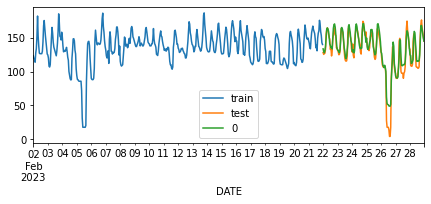

In [177]:
y_pred = regressor.predict(X_test)
y_pred = pd.DataFrame(y_pred).set_index(y_test.index)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

fig, ax = plt.subplots(figsize=(7, 2.5))
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='predictions')
ax.legend();

Permutation explainer: 169it [00:55,  2.50it/s]                         


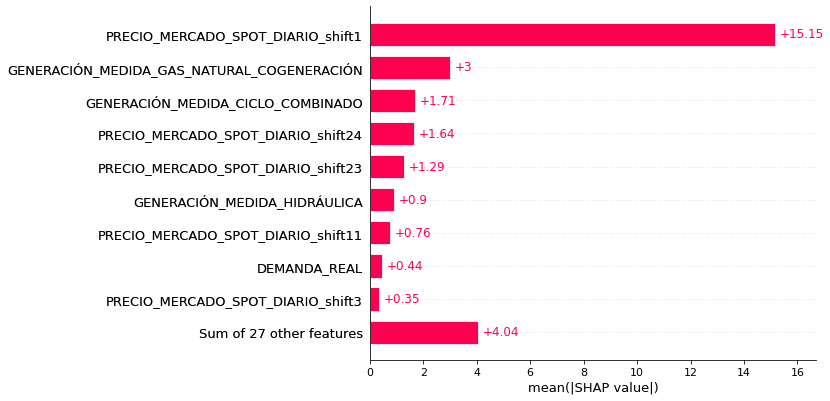

In [181]:
explainer = shap.Explainer(regressor.predict, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

Permutation explainer: 169it [00:54,  2.57it/s]                         


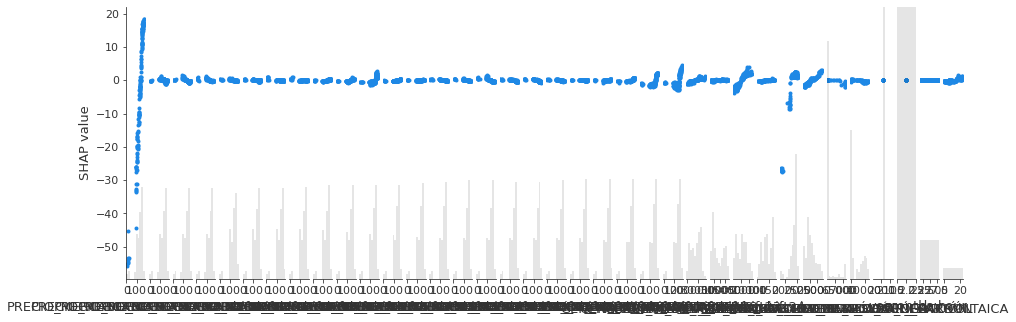

In [180]:
shap.plots.scatter(shap_values)

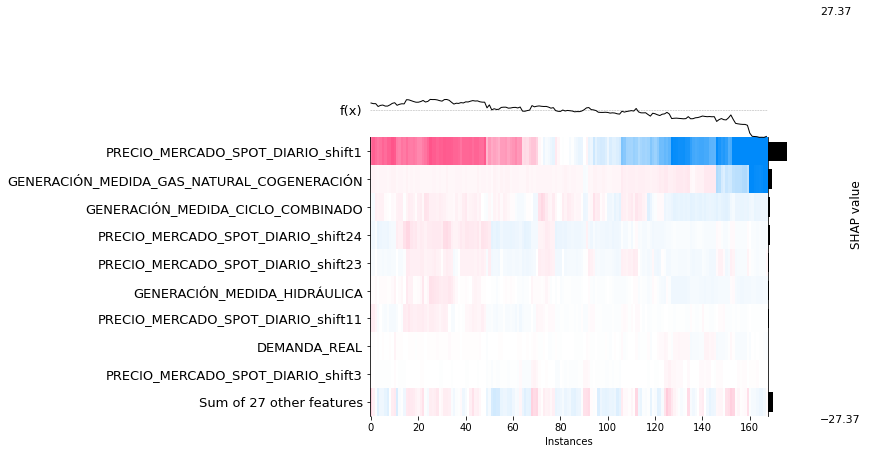

In [183]:
shap.plots.heatmap(shap_values)

In [5]:
train_window_size_list = [2, 5, 7, 14, 30]
train_window_size_list = [24*x for x in train_window_size_list]
forecasting_horizon = 24

cv_results_list = func.crossval_window_size_make_reduction(esios_spot, X, regressor, train_window_size_list, forecasting_horizon)

ValueError: The `window_length` and `fh` are incompatible with the length of `y`

In [8]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
#y_pred = forecaster.predict(fh=fh, X=X_test)

RandomForestRegressor()

In [78]:
explainer = shap.Explainer(regressor.predict, X_test)

In [79]:
shap_values = explainer(X_test)

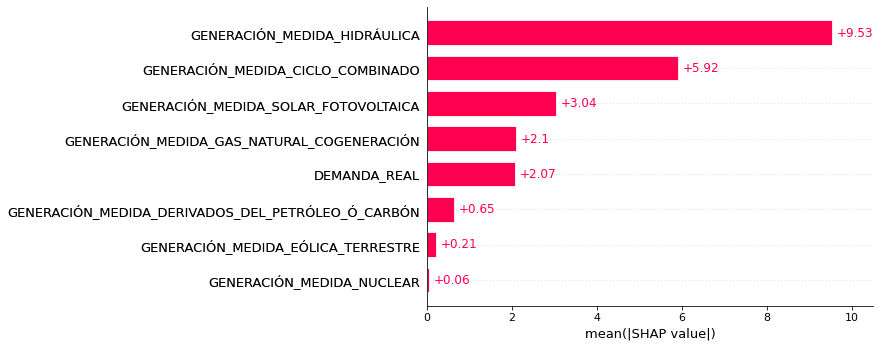

In [80]:
shap.plots.bar(shap_values)